In [1]:
import h5py

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import bilby

Get posterior sample from GWOSC

```
wget https://dcc.ligo.org/public/0157/P1800370/005/GW170817_GWTC-1.hdf5
```

In [2]:
posterior_sample_file = h5py.File('GW170817_GWTC-1.hdf5', 'r')

In [3]:
mass1_detector_frame = posterior_sample_file['IMRPhenomPv2NRT_lowSpin_posterior']['m1_detector_frame_Msun']
mass2_detector_frame = posterior_sample_file['IMRPhenomPv2NRT_lowSpin_posterior']['m2_detector_frame_Msun']

Text(0.5, 0, '$m_2$')

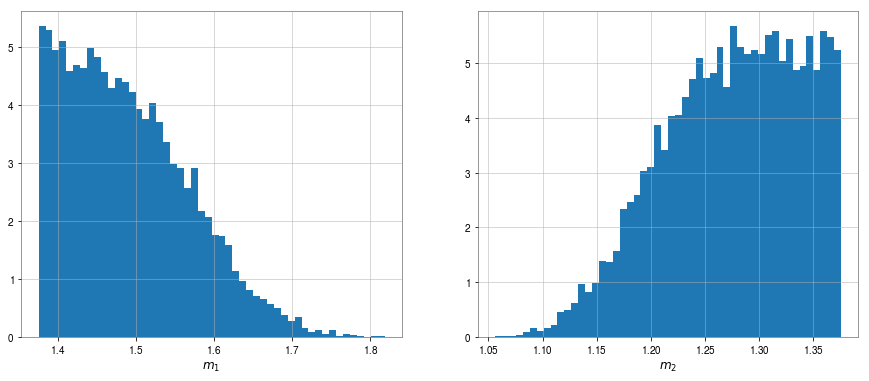

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.hist(mass1_detector_frame, bins=50, density=True)
ax2.hist(mass2_detector_frame, bins=50, density=True)

ax1.set_xlabel("$m_1$")
ax2.set_xlabel("$m_2$")

Text(0.5, 0, 'm_2')

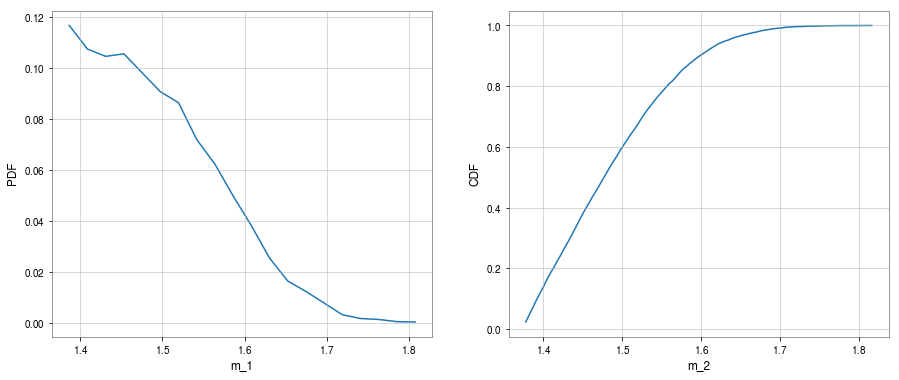

In [5]:
mm, bb = np.histogram(mass1_detector_frame, bins=20)
freq_mass_1 = mm/np.sum(mm)
bin_centers_freq_mass_1 = 0.5*(bb[1:] + bb[:-1])

mm, bb = np.histogram(mass1_detector_frame, bins=100)
cum_freq_mass_1 = np.cumsum(mm)/np.sum(mm)
bin_centers_cum_freq_mass_1 = 0.5*(bb[1:] + bb[:-1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(bin_centers_freq_mass_1, freq_mass_1)
ax2.plot(bin_centers_cum_freq_mass_1, cum_freq_mass_1)

ax1.set_ylabel('PDF')
ax1.set_xlabel('m_1')
ax2.set_ylabel('CDF')
ax2.set_xlabel('m_2')

In [6]:
m1_freq_interpolant  = sp.interpolate.interp1d(bin_centers_freq_mass_1, freq_mass_1, kind='cubic',
                                               fill_value=(0.,  0.), bounds_error=False)
m1_cum_freq_interpolant  = sp.interpolate.interp1d(bin_centers_cum_freq_mass_1, cum_freq_mass_1,
                                                   fill_value=(0,  1), bounds_error=False)

In [7]:
# for v in (1e-3, 0.1, 0.5, 1 - 1e-3, 1):
#     res = sp.optimize.brentq(lambda x: m1_cum_freq_interpolant(x) - v,
#                              m1_cum_freq_interpolant.x.min() - 1e-3,
#                              m1_cum_freq_interpolant.x.max() + 1e-3)
#     print(f"P-values = {v}; Result = {res}")

Text(0.5, 0, 'm_2')

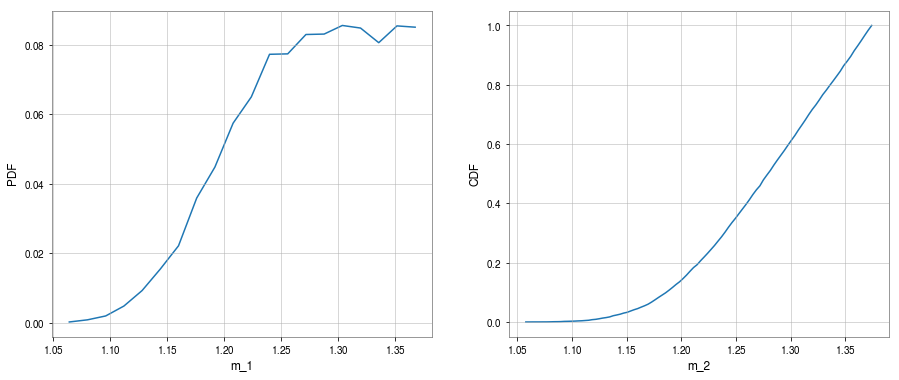

In [8]:
mm, bb = np.histogram(mass2_detector_frame, bins=20)
freq_mass_2 = mm/np.sum(mm)
bin_centers_freq_mass_2 = 0.5*(bb[1:] + bb[:-1])

mm, bb = np.histogram(mass2_detector_frame, bins=100)
cum_freq_mass_2 = np.cumsum(mm)/np.sum(mm)
bin_centers_cum_freq_mass_2 = 0.5*(bb[1:] + bb[:-1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(bin_centers_freq_mass_2, freq_mass_2)
ax2.plot(bin_centers_cum_freq_mass_2, cum_freq_mass_2)

ax1.set_ylabel('PDF')
ax1.set_xlabel('m_1')
ax2.set_ylabel('CDF')
ax2.set_xlabel('m_2')

In [9]:
m2_freq_interpolant  = sp.interpolate.interp1d(bin_centers_freq_mass_2, freq_mass_2,
                                               fill_value=(0.,  0.), bounds_error=False)
m2_cum_freq_interpolant  = sp.interpolate.interp1d(bin_centers_cum_freq_mass_2, cum_freq_mass_2,
                                                   fill_value=(0.,  1), bounds_error=False)

In [10]:
class CustomMassPrior(bilby.prior.Prior):    
    def __init__(self, *args, **kwargs):
        """Prior using on masses.
        
        Notes
        -----
        First two arguments are `scipy.interpolate.interp1d`
        instances for the PDF and CDF of the mass posterior.
        samples.
        """
        interpolant_pdf, interpolant_cdf, *args = args

        kwargs['minimum'] = interpolant_pdf.x.min()
        kwargs['maximum'] = interpolant_pdf.x.max()

        self.interpolant_pdf = interpolant_pdf
        self.interpolant_cdf = interpolant_cdf

        super().__init__(*args, **kwargs)

    def prob(self, val):
        return self.interpolant_pdf(val)

    def ln_prob(self, val):
        return np.log(self.prob(val))

    def rescale(self, val):
        self.test_valid_for_rescaling(val)
        if not hasattr(val, 'size') or val.size==1:
            return self._rescale(val)
        else:
            return np.array(
                [self._rescale(v) for v in val]
            )
    def _rescale(self, val):
        try:
            res = sp.optimize.brentq(
                lambda z: self.interpolant_cdf(z) - val,
                self.minimum, self.maximum
            )
        except ValueError as e:  # pathological issue at the boundaries
            if e.__str__() != 'f(a) and f(b) must have different signs':
                raise
            res = np.random.uniform(self.minimum, self.maximum)
        return res

In [11]:
m1_prior = CustomMassPrior(m1_freq_interpolant, m1_cum_freq_interpolant)

Text(0.5, 0, 'm_1')

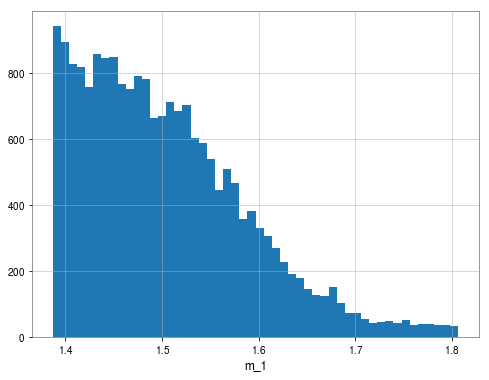

In [12]:
plt.figure(figsize=(8, 6))
samples = m1_prior.sample(20000)
plt.hist(samples, bins=50)
plt.xlabel('m_1')

In [13]:
m2_prior = CustomMassPrior(m2_freq_interpolant, m2_cum_freq_interpolant)

Text(0.5, 0, 'm_2')

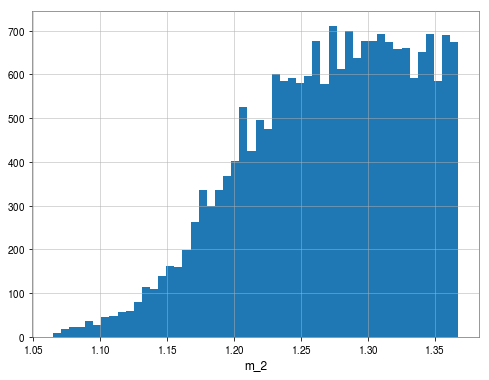

In [14]:
plt.figure(figsize=(8, 6))
samples = m2_prior.sample(20000)
plt.hist(samples, bins=50)
plt.xlabel('m_2')

## Use in bilby Priordict

In [15]:
prior_dictionary = dict(
    mass_1=CustomMassPrior(m1_freq_interpolant, m1_cum_freq_interpolant),
    mass_2=CustomMassPrior(m2_freq_interpolant, m2_cum_freq_interpolant),
    a_1=bilby.gw.prior.Uniform(name='a_1', minimum=0, maximum=0.05,
                               latex_label='$a_1$', unit=None, boundary=None),
    a_2=bilby.gw.prior.Uniform(name='a_2', minimum=0, maximum=0.05,
                               latex_label='$a_2$', unit=None, boundary=None),
    tilt_1=bilby.prior.Sine(name='tilt_1', latex_label='$\\theta_1$', unit=None),
    tilt_2=bilby.prior.Sine(name='tilt_2', latex_label='$\\theta_2$', unit=None),
    phi_12=bilby.gw.prior.Uniform(name='phi_12', minimum=0, maximum=2 * np.pi,
                                  boundary='periodic', latex_label='$\\Delta\\phi$', unit=None),
    phi_jl=bilby.gw.prior.Uniform(name='phi_jl', minimum=0, maximum=2 * np.pi,
                                  boundary='periodic', latex_label='$\\phi_{JL}$', unit=None),
    luminosity_distance=bilby.gw.prior.UniformComovingVolume(name='luminosity_distance',
                                                             minimum=1, maximum=75, latex_label='$d_L$',
                                                             unit='Mpc', boundary=None),
    dec=bilby.prior.Cosine(name='dec', latex_label='$\\mathrm{DEC}$',
                           unit=None, minimum=-np.pi / 2, maximum=np.pi / 2, boundary=None),
    ra=bilby.gw.prior.Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic',
                              latex_label='$\\mathrm{RA}$', unit=None),
    theta_jn=bilby.prior.Sine(name='theta_jn', latex_label='$\\theta_{JN}$',
                              unit=None, minimum=0, maximum=np.pi, boundary=None),
    psi=bilby.gw.prior.Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic',
                               latex_label='$\\psi$', unit=None)
)


bns_prior = bilby.gw.prior.BBHPriorDict(dictionary=prior_dictionary)

In [16]:
sample = bns_prior.sample(20000)

In [17]:
m1 = sample['mass_1']
m2 = sample['mass_2']

Text(0.5, 0, '$m_2$')

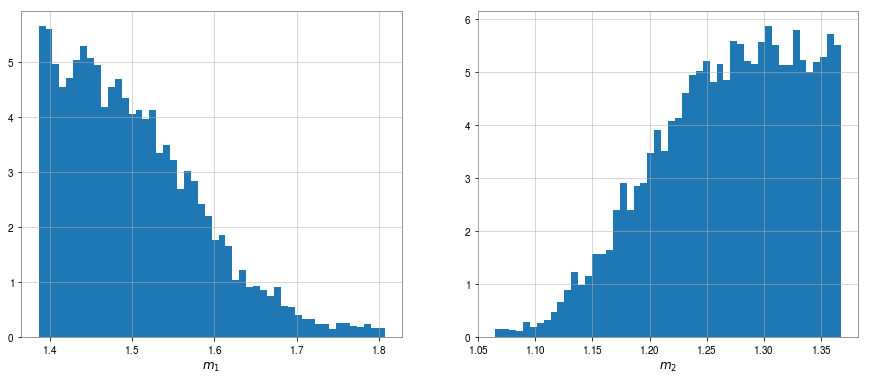

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.hist(m1, bins=50, density=True)
ax2.hist(m2, bins=50, density=True)

ax1.set_xlabel("$m_1$")
ax2.set_xlabel("$m_2$")